In [15]:
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from scipy.stats import percentileofscore
from scipy import stats
import matplotlib
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 500) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', 500)


df = pd.read_csv("C:/Users/nikos/PycharmProjects/ptuxiaki/all_events_final1_fscore_wind.csv", sep = ";") #../input/student-mat.csv
df.head()

,Vmean,Vmax,Bmax,VmBm,MagnM,Bdo_Bup,DV,Ndo_Nup,Thita
0,312,429,17.3,3.71,1.7,1.63,27,1.68,37
1,505,468,15.2,3.56,2.5,2.97,26,2.57,51
2,600,524,25.3,6.63,4.3,2.49,76,2.26,86
3,378,358,11.0,1.97,2.3,1.69,22,1.78,57
4,434,560,17.3,4.84,3.3,1.85,30,1.83,88


In [86]:
df.shape

(146, 9)

In [87]:
df.describe()

,Vmean,Vmax,Bmax,VmBm,MagnM,Bdo_Bup,DV,Ndo_Nup,Thita
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,720.376712,579.253425,19.948630,6.121096,5.003425,2.294863,103.773973,2.403562,58.136986
std,221.954178,141.034054,9.285311,4.253935,3.560597,0.745308,71.131328,0.714846,20.793112
min,312.000000,356.000000,7.200000,1.410000,0.600000,1.300000,21.000000,1.210000,4.000000
25%,573.000000,468.250000,13.925000,3.332500,2.425000,1.755000,52.750000,1.932500,41.000000
50%,657.500000,535.000000,18.050000,5.065000,3.850000,2.135000,86.000000,2.245000,62.000000
75%,851.000000,671.750000,24.100000,7.542500,6.600000,2.625000,131.750000,2.662500,74.750000
max,1384.000000,1059.000000,56.900000,29.590000,16.400000,5.580000,361.000000,5.740000,89.000000


In [88]:
numerical_values = df.select_dtypes(include = ['float64', 'int64']).columns.values
numerical_values

array(['Vmean', 'Vmax', 'Bmax', 'VmBm', 'MagnM', 'Bdo_Bup', 'DV',
       'Ndo_Nup', 'Thita'], dtype=object)

In [6]:
k=df.corr()['MagnM'].sort_values()
print(k)

Thita      0.093872
Ndo_Nup    0.258193
Bdo_Bup    0.335826
Vmean      0.642325
DV         0.650885
Bmax       0.702628
Vmax       0.710841
VmBm       0.772384
MagnM      1.000000
Name: MagnM, dtype: float64


In [90]:
df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,Vmean,Vmax,Bmax,VmBm,MagnM,Bdo_Bup,DV,Ndo_Nup,Thita
Vmean,1.000000,0.774938,0.668752,0.846417,0.469022,0.686178,0.667155,0.642363,0.405272
Vmax,0.774938,1.000000,0.687610,0.828687,0.484984,0.672546,0.682664,0.672724,0.372711
Bmax,0.668752,0.687610,1.000000,0.749508,0.558433,0.710582,0.620613,0.604314,0.331782
VmBm,0.846417,0.828687,0.749508,1.000000,0.491255,0.780633,0.725479,0.681569,0.390157
MagnM,0.469022,0.484984,0.558433,0.491255,1.000000,0.470137,0.399673,0.368170,0.211066
Bdo_Bup,0.686178,0.672546,0.710582,0.780633,0.470137,1.000000,0.679072,0.638716,0.305025
DV,0.667155,0.682664,0.620613,0.725479,0.399673,0.679072,1.000000,0.488705,0.277929
Ndo_Nup,0.642363,0.672724,0.604314,0.681569,0.368170,0.638716,0.488705,1.000000,0.298752
Thita,0.405272,0.372711,0.331782,0.390157,0.211066,0.305025,0.277929,0.298752,1.000000


In [28]:
def format_data(df):
    
    labels = df['MagnM']

    #df = df.drop(columns=['VmBm', 'Vmax'])
    df = pd.get_dummies(df)
    
    # Find correlations with the MagnM
    most_correlated = df.corr().abs()['MagnM'].sort_values(ascending=False)
    
    # top 5 most correlation features with MagnM
    most_correlated = most_correlated[:7]
    
    df = df.loc[:, most_correlated.index]
    #df = df.drop(columns = 'Thita')
    
    #training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
    test_size = 0.25,
    random_state=42)
    
    return X_train, X_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,MagnM,VmBm,Vmax,Bmax,DV,Vmean,Bdo_Bup
84,6.5,4.10,573,14.3,162,752,3.68
68,12.3,29.59,1040,56.9,314,1323,5.20
51,3.2,3.16,549,11.5,138,674,2.30
135,0.9,2.76,422,13.1,67,666,2.22
134,3.6,2.46,439,11.2,40,428,1.61


In [30]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true)) #mean absolute error
    rmse = np.sqrt(np.mean((predictions - true) ** 2)) #relative
    
    return mae, rmse

In [94]:
# Evaluate several machine learning models
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 
                      'Random Forest', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='MagnM')
    X_test = X_test.drop(columns='MagnM')
    
    #the models
    model1 = LinearRegression()
    model2 = RandomForestRegressor(n_estimators=50)
    model3 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model4 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict
    for i, model in enumerate([model1, model2, model3, model4]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [95]:
results = evaluate(X_train, X_test, y_train, y_test)

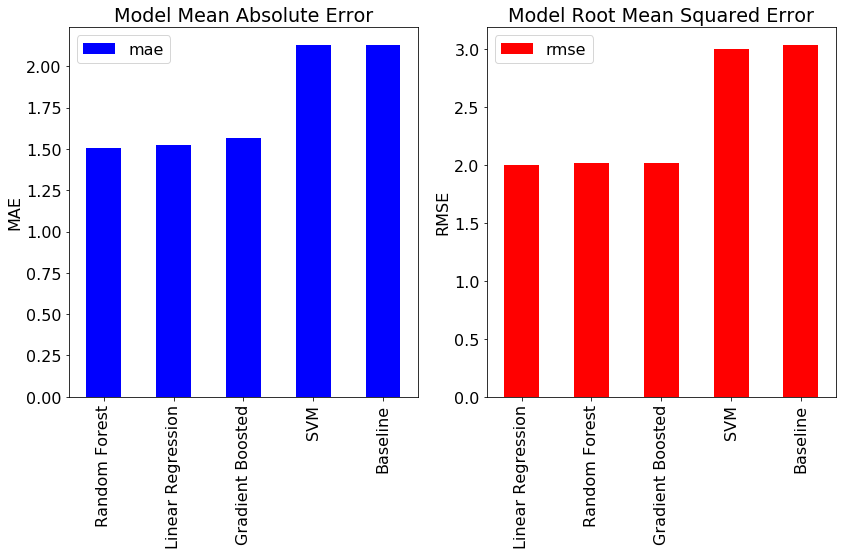

In [96]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [97]:
results

,mae,rmse
Linear Regression,1.52354,2.00256
Random Forest,1.5047,2.01805
SVM,2.12857,3.00121
Gradient Boosted,1.56519,2.0218
Baseline,2.12973,3.03707


In [98]:
# Model for Bayesian Linear Regression 
model_blm = 'MagnM ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
model_blm

'MagnM ~ VmBm + Vmax + Bmax + DV + Vmean + Bdo_Bup'

In [99]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 26.51% better than the baseline.


In [100]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='MagnM'), y_train)

ols_formula = 'MagnM = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'MagnM = -5.33 + -0.12 * VmBm + 0.01 * Vmax + 0.19 * Bmax + 0.01 * DV + 0.00 * Vmean + -0.20 * Bdo_Bup'

In [101]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'MagnM ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'MagnM ~ VmBm + Vmax + Bmax + DV + Vmean + Bdo_Bup'

In [102]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, Bdo_Bup, Vmean, DV, Bmax, Vmax, VmBm, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 4881 seconds.
The acceptance probability does not match the target. It is 0.9177470472979341, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9575984781761283, but should be close to 0.8. Try to increase the number of tuning steps.


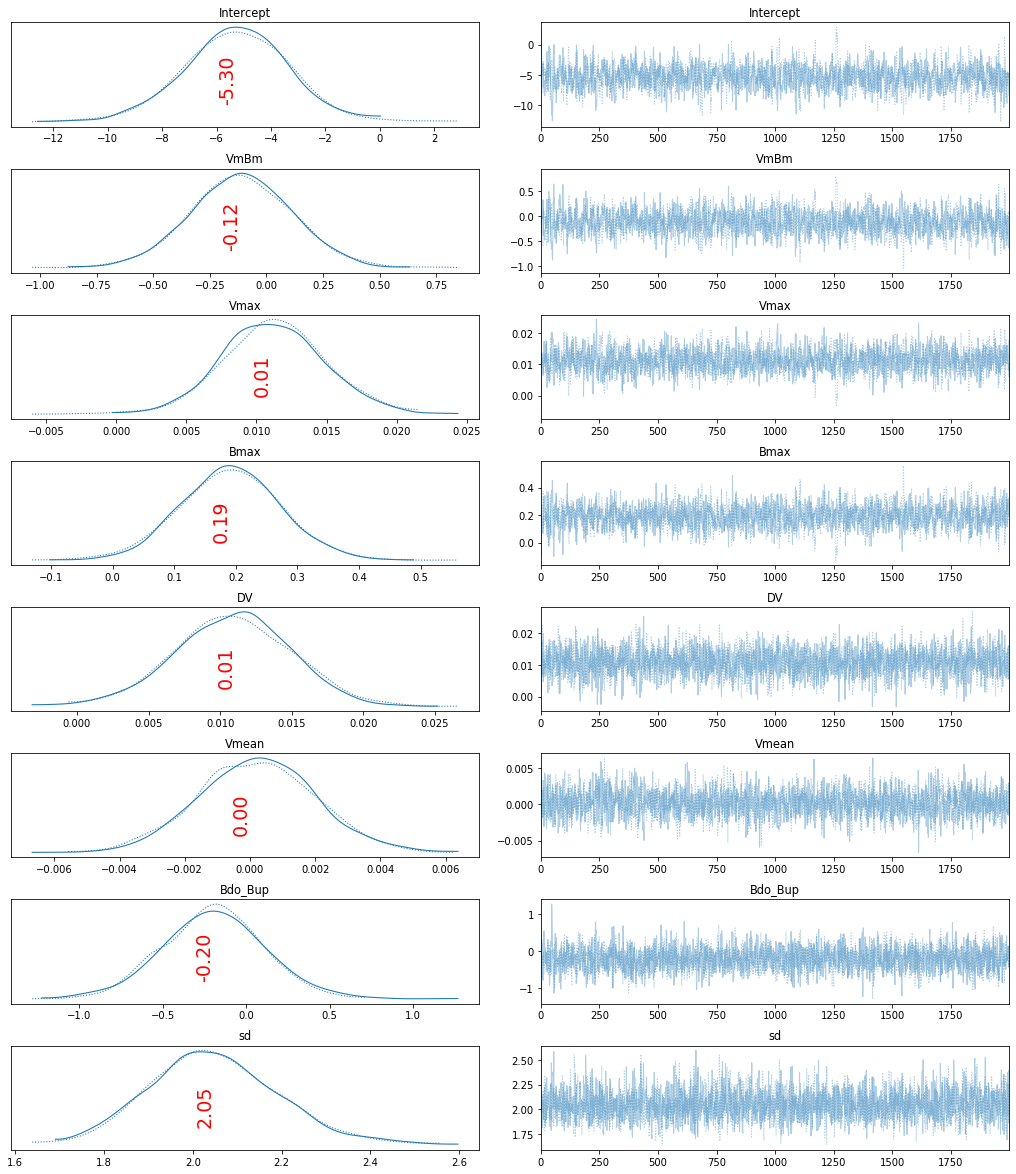

In [103]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

plot_trace(normal_trace);


In [104]:
model_formula = 'MagnM =' #formula gia na dw to modelo einai auto se mathimatiki morfi
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)
 
' '.join(model_formula.split(' ')[:-1])


'MagnM = -5.30 * Intercept + -0.11 * VmBm + 0.01 * Vmax + 0.19 * Bmax + 0.01 * DV + 0.00 * Vmean + -0.20 * Bdo_Bup + 0.71 * sd_log__ + 2.05 * sd'

Test Observation:
MagnM        4.30
VmBm         4.07
Vmax       586.00
Bmax        13.90
DV         128.00
Vmean      616.00
Bdo_Bup      2.13
Name: 60, dtype: float64
True MagnM= 4
Average Estimate = 4.4984
5% Estimate = 0.9453    95% Estimate = 7.6017


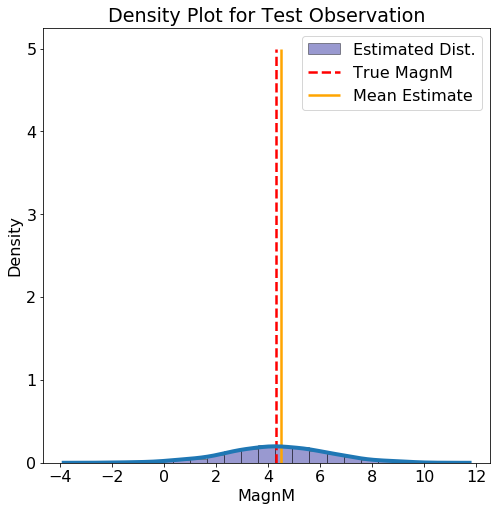

In [105]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['MagnM']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('MagnM')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True MagnM',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('MagnM'); plt.ylabel('Density');
    
    # Prediction information
    print('True MagnM= %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

test_model(normal_trace, X_test.iloc[16])

In [106]:
# Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.2f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: -5.30
Variable: VmBm            Mean weight in model: -0.11
Variable: Vmax            Mean weight in model: 0.01
Variable: Bmax            Mean weight in model: 0.19
Variable: DV              Mean weight in model: 0.01
Variable: Vmean           Mean weight in model: 0.00
Variable: Bdo_Bup         Mean weight in model: -0.20
Variable: sd_log__        Mean weight in model: 0.71
Variable: sd              Mean weight in model: 2.05


In [64]:
from sklearn import preprocessing
X = df.drop( "MagnM" , axis= 1 )
X= preprocessing.scale(X)
y = df["MagnM"]
y= preprocessing.scale(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 ,random_state=110)

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)#labed gia binary
y_test_encoded = lab_enc.fit_transform(y_test)


In [65]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)#labed gia binary
y_test_encoded = lab_enc.fit_transform(y_test)

In [67]:
from sklearn.model_selection import GridSearchCV
param = {'kernel' : ['poly','rbf','linear','sigmoid'],
         'C' : [1,5,10],'degree' : [3,8],
        'coef0' : [0.01,10,0.5],
       'gamma' : ('auto','scale')}
modelsvr = SVR()
grids = GridSearchCV(modelsvr,param,cv=5)
grids.fit(X_train,y_train)
grids.best_params_
print(grids.best_params_)

{'C': 1, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
C:\Users\nikos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [69]:
regressor = SVR(kernel='linear',degree=3,gamma='auto',coef0=0.01,C=1)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

In [70]:
dff = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(dff)

Actual  Predicted
0   1.492673   0.120028
1  -0.846421  -0.758704
2   1.182673   0.597198
3  -0.480057  -0.828606
4  -0.057329  -0.597741
5  -0.085511   0.038632
6  -0.705512  -0.171590
7  -0.761875  -0.824743
8   0.929036   0.453670
9  -0.620966  -0.362441
10  0.449945  -0.060142
11 -0.423693  -0.640805
12 -0.677330  -0.517549
13  1.577219   1.391306
14 -0.620966  -0.368193
15  0.816309   1.451090
16 -0.987330  -1.026612
17  0.224490   0.685324
18 -0.310966  -0.863677
19 -0.339147  -0.276958
20 -0.113693  -0.627782
21 -0.987330  -0.811958
22 -0.536420  -0.353318
23  2.056310   4.074732
24 -0.874603  -0.355606
25 -0.959148  -0.902614
26  0.562672   0.255778
27 -0.254602  -0.542388
28 -0.226420   0.538480
29  2.760857   0.865925
30 -0.649148  -0.708614
31  1.999947   1.133458
32  0.309035   0.894942
33  0.196308   0.610491
34 -0.705512   0.040109
35  0.224490   0.141326
36 -0.761875  -0.322873


In [71]:
from sklearn import metrics
print(regressor.intercept_)
#print({'Parameter': sharps, 'corellation0': regressor.coef_})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('function:', metrics.(y_test, y_pred))

[-0.04370677]
Mean Absolute Error: 0.46972831074100047
Mean Squared Error: 0.4231268507155796
Root Mean Squared Error: 0.6504820141368857


In [72]:
plt.scatter(X, y, color = 'magenta')
plt.plot(X, regressor.predict(X), color = 'green')
plt.title('(Support Vector Regression Model)')
plt.xlabel('feat')
plt.ylabel('A0')
plt.show()

ValueError: x and y must be the same size